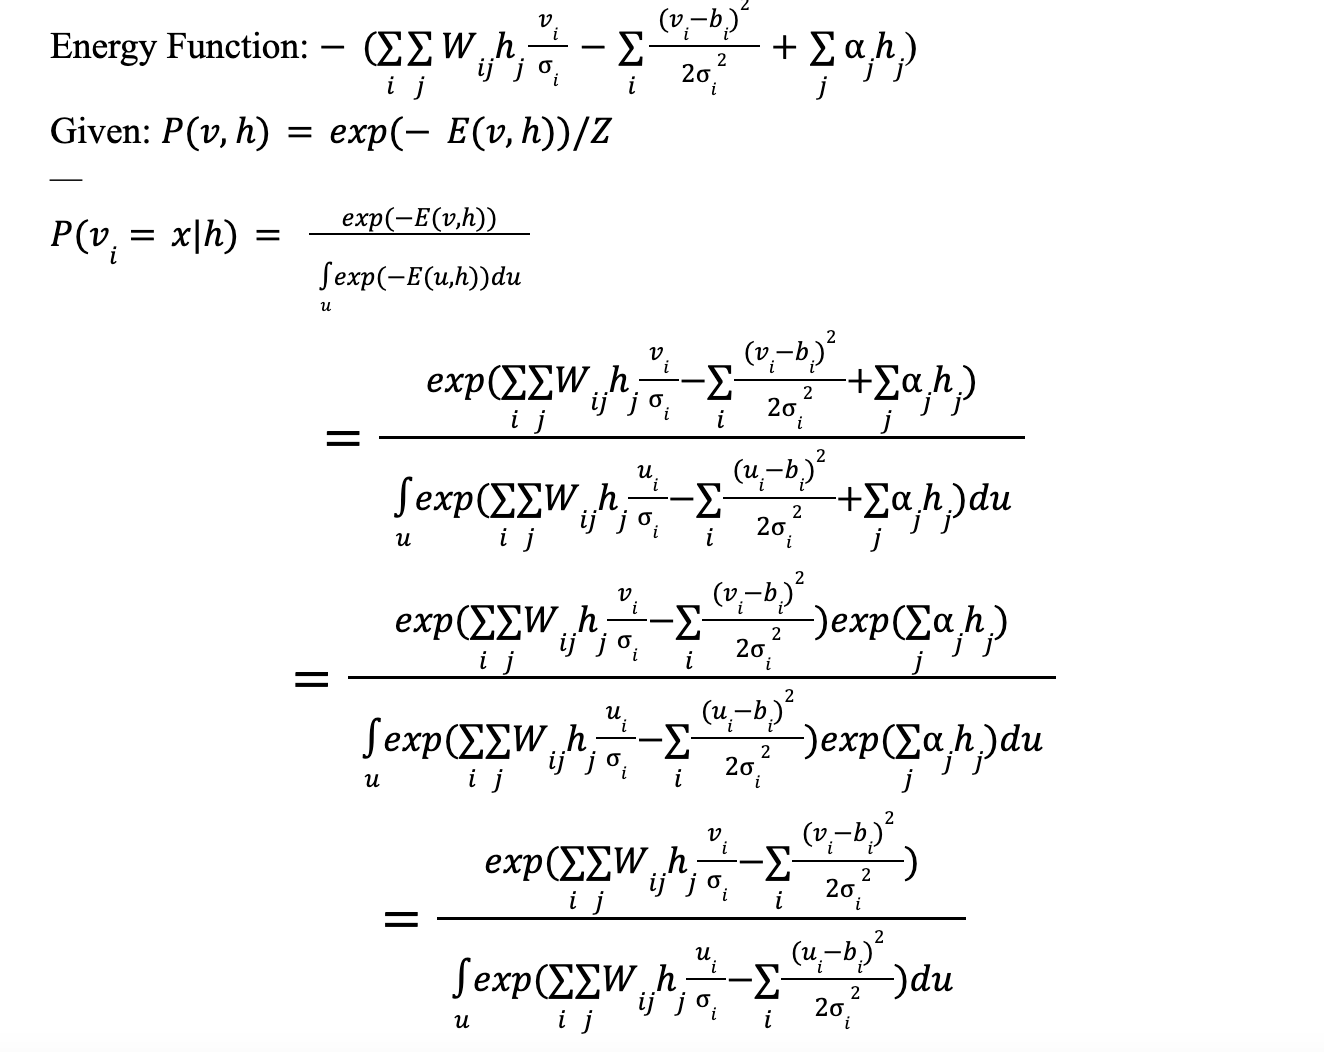

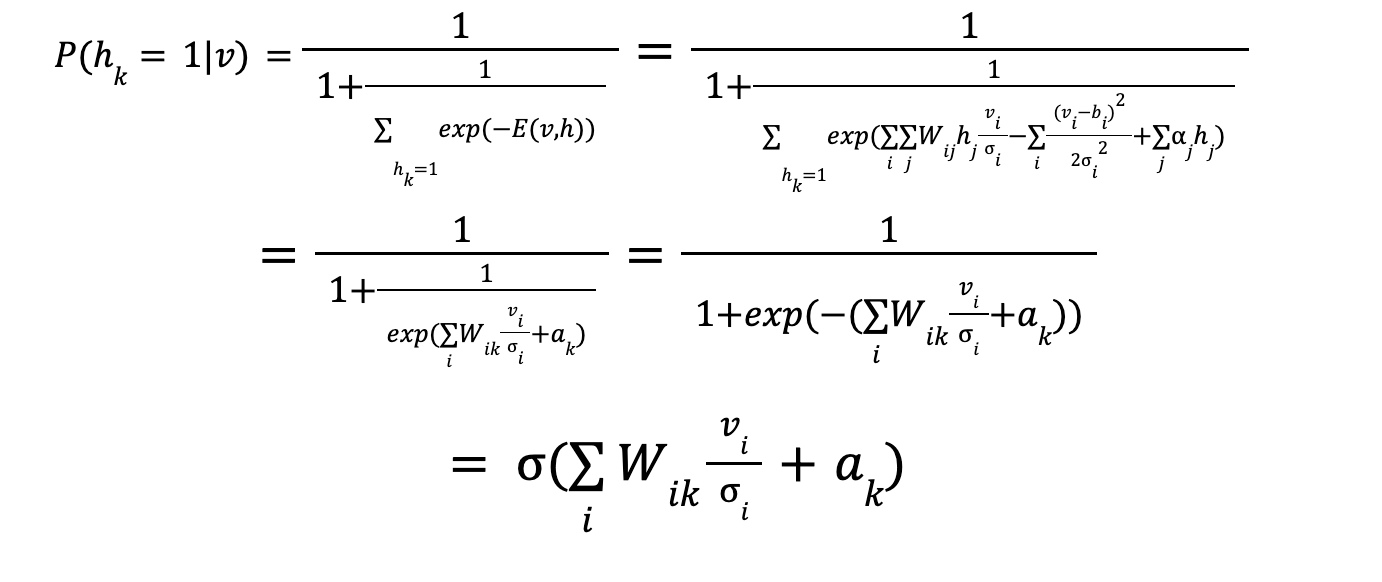

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.optim as optim
import torch.distributions as D

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size = 128
train_set, test_set, train_loader, test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set['fashionmnist'] = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set['fashionmnist'] = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader['fashionmnist'] = torch.utils.data.DataLoader(train_set['fashionmnist'], batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['fashionmnist'] = torch.utils.data.DataLoader(test_set['fashionmnist'], batch_size=batch_size, shuffle=False, num_workers=0)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
class RBM(nn.Module):
    """Gaussian Bernoulli Restricted Boltzmann Machine"""
    
    def __init__(self, D: int, F: int, k: int):
        """Creates an instance RBM module"""
        
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(F, D) * 1e-2) 
        self.c = nn.Parameter(torch.zeros(D)) 
        self.b = nn.Parameter(torch.zeros(F)) 
        self.k = k
    
    def P_h_x(self, x):
        """Returns the conditional P(h|x)"""
            
        ph_x = torch.sigmoid(F.linear(x, self.W, self.b))
        return ph_x
    
    def bern_sample(self, p):
        """Sample from a Bernoulli distribution"""
        
        return torch.distributions.Bernoulli(p).sample()
    
    def P_x_h(self, h):
        """Returns the conditional P(x|h)"""
        
        px_h = torch.sigmoid(F.linear(h, self.W.t(), self.c))
        return px_h
    
    def normal_sample(self, p):
        """Sample from a Gaussian distribution"""
        
        return p + torch.randn(p.shape)
    
    def forward(self, x):
        """Generates x_negative using MCMC Gibbs sampling starting from x"""
        
        x_negative = x
        for _ in range(self.k):
            
            phx_k = self.P_h_x(x_negative) 
            h_negative = self.bern_sample(phx_k)
            pxh_k = self.P_x_h(h_negative)
            x_negative = self.normal_sample(pxh_k)

        return x_negative, pxh_k
    
    def h(self, x):
        return torch.sigmoid(F.linear(x, self.W, self.b))
    
    def cdk_algo(self, training_data, alpha):
        """Contrastive Divergence training algorithm"""
        
        for batch_idx, (data, target) in enumerate(training_data):
            data = data.view(data.size(0),-1) 
            h_x = self.h(data)
            x_negative, _ = self.forward(data)
            h_x_neg = self.h(x_negative) 
            with torch.no_grad():
                self.W += alpha * (torch.matmul(h_x.t(), data)) - (torch.matmul(h_x_neg.t(), x_negative))
                b_update_data = h_x - h_x_neg
                for i in range(b_update_data.shape[0]):
                    self.b += alpha * b_update_data[i]
                c_update_data = data - x_negative
                for j in range(c_update_data.shape[0]):
                    self.c += alpha * c_update_data[j]
            
    

In [4]:
def training(input_model, learning_rate, epochs=25):
    input_model.train()
    for epoch in range(epochs):
        input_model.cdk_algo(train_loader['fashionmnist'], learning_rate) 
    
    input_model.eval()
    criterion = torch.nn.MSELoss()
    test_loss = 0
    
    with torch.no_grad():
        for batch_idx_t, (data_t, labels_t) in enumerate(test_loader['fashionmnist']):
            data_t = data_t.view(data_t.size(0),-1)
            x_tilda_t, _ = input_model(data_t)
            loss_t = criterion(data_t, x_tilda_t)
            test_loss += loss_t.item() 
    
    print("Test Reconstruction MSE:")
    print(test_loss) 
    print("------------------------") 

In [5]:
M = [10, 50, 100, 250]
for hd in M:
    rbm = RBM(D=28*28, F=hd, k=5)
    print("M value:")
    print(hd)
    training(rbm, 0.001) 

M value:
10
Test Reconstruction MSE:
85.88348948955536
------------------------
M value:
50
Test Reconstruction MSE:
85.87234270572662
------------------------
M value:
100
Test Reconstruction MSE:
85.91625487804413
------------------------
M value:
250
Test Reconstruction MSE:
85.81427431106567
------------------------
